In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache
from typing import Union, Optional, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from modAL.uncertainty import classifier_uncertainty
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [8]:
X, y = car()

In [9]:
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y)

In [10]:
clf = svm.SVC(kernel='linear', probability=True)

In [11]:
clf.fit(X_labelled, y_labelled)

SVC(kernel='linear', probability=True)

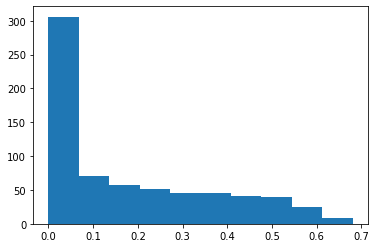

In [12]:
plt.hist(classifier_uncertainty(clf, X_unlabelled));

In [13]:
n_instances = 10

In [14]:
classifier = ScikitlearnSVC(
    model=clf, clip_values=None
)

attack = FastGradientMethod(classifier, minimal=True)

adversarial_examples = attack.generate(X)

# TODO: Investigate performance of different distance metrics
dists = paired_distances(X, adversarial_examples, metric="euclidean")

idx = np.argsort(dists)

# This is kind of a hack, modAL is not built to deal with passing extra information.
result = (
    idx[:n_instances],
    #adversarial_examples[idx[:n_instances]] if teach_adversarial else None,
)

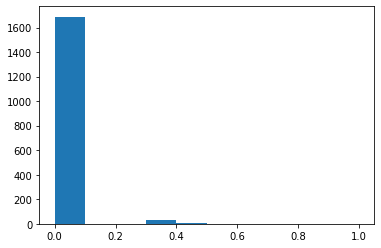

In [15]:
plt.hist(1-dists/np.max(dists));

In [2]:
def adversarial_batch_sampling(classifier,
                               X: Union[np.ndarray],
                               Attack: Callable,
                               n_instances: int = 20,
                               metric: Union[str, Callable] = 'euclidean',
                               n_jobs: Optional[int] = None,
                               clip_values = None
                               ) -> np.ndarray:
    from modAL.batch import ranked_batch
    
    aclassifier = ScikitlearnSVC(
        model=classifier.estimator, clip_values=clip_values
    )

    attack = Attack(aclassifier)

    adversarial_examples = attack.generate(X)

    # TODO: Investigate performance of different distance metrics
    dists = paired_distances(X, adversarial_examples, metric="euclidean")

    norm_dists = 1-dists/np.max(dists)
    
    return ranked_batch(classifier, unlabeled=X, uncertainty_scores=norm_dists,
                                 n_instances=n_instances, metric=metric, n_jobs=n_jobs)

In [13]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("car", lambda: lru_cache()(car)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
        ("deepfool batch", partial(adversarial_batch_sampling, Attack=partial(DeepFool, verbose=False), n_instances=10)),
        ("hopskipjump batch", partial(adversarial_batch_sampling, Attack=partial(HopSkipJump, verbose=False), n_instances=10)),
        ("hopskipjump", partial(adversarial, Attack=partial(HopSkipJump, verbose=False), n_instances=10)),
    ],
    "models": [
        # isn't actually parsed to anything yet
        ("SVM-linear", partial(svm.SVC, kernel='linear', probability=True))
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.05,
        "n_runs": 10
    }
}

In [15]:
reload(librun)

<module 'librun' from 'C:\\Users\\Zac\\Programming\\python\\research\\librun.py'>

In [16]:
results = librun.run(matrix, workers=3, metrics=[accuracy_score,f1_score,roc_auc_score,empirical_robustness,"time"])

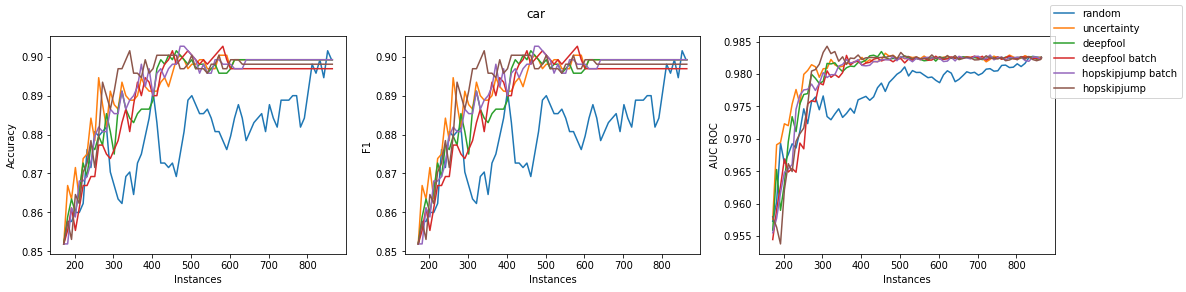

In [5]:
librun.plot(results)

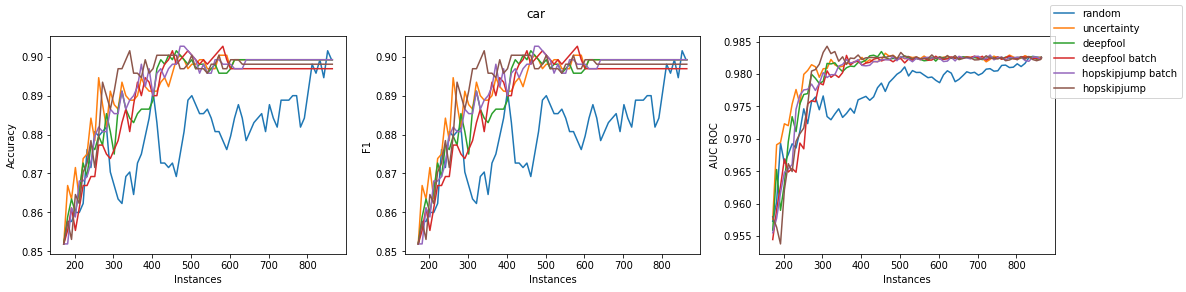

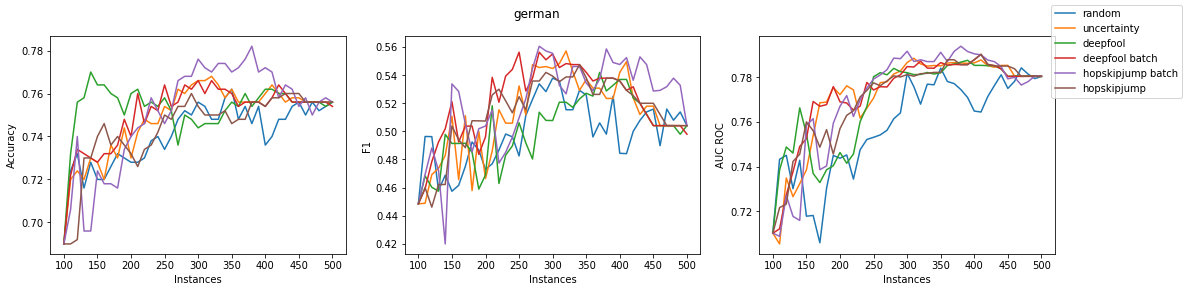

In [8]:
librun.plot(results)

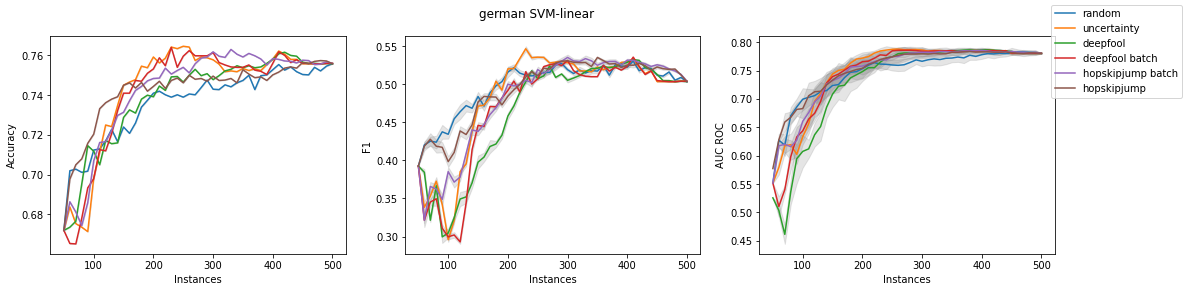

In [20]:
reload(librun)
librun.plot(results)

In [38]:
reload(librun)
librun.table(results)

german
╒═══════════════════╤═══════════╤════════════╤═══════════════╤═════════════════════════════╤════════════════════════════╤═══════════╕
│ method            │ AUC LAC   │ AUC LF1C   │ AUC AUC ROC   │ Instances to max accuracy   │ Instances to max AUC ROC   │      Time │
╞═══════════════════╪═══════════╪════════════╪═══════════════╪═════════════════════════════╪════════════════════════════╪═══════════╡
│ uncertainty       │ 334.78±1  │ 217.84±3   │ 338.06±2      │ 200±20                      │ 220±0                      │    0.3342 │
├───────────────────┼───────────┼────────────┼───────────────┼─────────────────────────────┼────────────────────────────┼───────────┤
│ hopskipjump batch │ 334.36±2  │ 217.79±5   │ 337.22±2      │ 280±60                      │ 280±10                     │ 1589.4    │
├───────────────────┼───────────┼────────────┼───────────────┼─────────────────────────────┼────────────────────────────┼───────────┤
│ hopskipjump       │ 334.36±2  │ 222.68±4   │ 339.19±2

No significant difference in:

* Area under learning curve: Accuracy, F1, ROC AUC
* Instances to max ROC AUC

Significant difference in:

* Instances to max accuracy (improved by batch)